# Models training
In this notebook we train and analyze multiple models, compare them and tune them to get the best results. We will work with a small subset due to low hardware availability.

## 0.1 Load variable
This notebook is a direct continuation of data_preprocessing.ipynb. We start by loading the necessary libraries variables from that.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from collections import Counter
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


with open('landmarks_subset_proccessed.pkl', 'rb') as file:
    subset_landmarks = pickle.load(file)

data_info = pd.read_csv('video_labels.csv',dtype={'video_id': object})
subset_words = ['tall', 'man', 'red', 'shirt', 'play', 'basketball', 'cold', 'pizza', 'top', 'cheese', 'taste',
                'delicious', 'lazy', 'afternoon', 'dark', 'room', 'small', 'lamp', 'empty',
                'big', 'dog', 'walk', 'beautiful', 'every', 'morning', 'short',
                'woman', 'wear', 'dress', 'have', 'beautiful', 'daughter']


POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1
videos_per_word = Counter(data_info.loc[data_info.word.isin(subset_words),'word'])

In [16]:
def pick_frames(video, num_frames):
    step_size = len(video) // num_frames
    video_shorter = video[::step_size][:num_frames]
    return video_shorter

def pick_frames_for_all(videos):
    standard_videos = {}
    for x in videos:
        shorter = pick_frames(videos[x], 20)
        standard_videos[x] = shorter
    return standard_videos

standard_videos = pick_frames_for_all(subset_landmarks)

In [17]:
print(len(standard_videos))

274


In [18]:
num_of_words = data_info[data_info["word"].isin(subset_words)]["word"].nunique()
subset_data = data_info[data_info["word"].isin(subset_words)]
subset_train_data = subset_data[subset_data["signer_id"].isin(
    [118, 31, 59, 11, 115, 94, 6, 21, 10, 38, 56, 41, 4, 45, 32, 46, 13, 42, 39, 17, 89, 60, 35, 15, 3, 92, 93, 34, 107, 28, 99, 37, 8, 97, 70, 19, 91, 106, 63, 29, 26, 117, 66, 119, 50, 103, 120, 95, 78, 27, 108, 57, 53, 75, 104, 43, 40, 77, 1, 33, 22, 105, 48, 73, 23])]
subset_test_data = subset_data[subset_data["signer_id"].isin([2, 52, 12, 98, 88])]
subset_validation_data = subset_data[subset_data["signer_id"].isin([59, 115, 90, 4, 116, 100, 101, 102, 96, 90,])]

print(f"subset train data count: {len(subset_train_data)}")
print(f"subset test data count: {len(subset_test_data)}")
print(f"subset validation data count: {len(subset_validation_data)}")
print(f"num of words: {num_of_words}")

subset train data count: 202
subset test data count: 37
subset validation data count: 32
num of words: 31


# 1.0 Unsupervised - Base Model
We first try and distinguish the words without letting the model know the labels.



# 1.1 Dynamic Time Wrapping and KMeans (DTW)
Dynamic Time Wrapping can detect similar motions but its computation is slow, let's take videos of two words only, without the face (which has the majority of landmarks) and check whether it is a good approach.

We start with a sainity check for DTW. Just a few sample to keep computations reasonably quick.

In [25]:

#words = ["play","basketball","morning","tall","dress","beautiful"]
#words = ["short", "tall", "woman", "man","small", "big", "morning", "afternoon", ]
#for word in words:
    #print(word, videos_per_word[word])

dtw_landmarks = {}
for word in subset_train_data["word"].unique():
    videos = subset_train_data.loc[subset_train_data.word==word,'video_id']
    # Exclude augmented videos for now
    for vid in videos[:2]:
        dtw_landmarks[vid] = standard_videos[vid][:,POSE+LH+RH,:]
print(len(dtw_landmarks))
dtw_landmarks

62


{'62175': array([[[ 0.4445011 ,  0.21856713, -1.2212925 ],
         [ 0.46559986,  0.18403697, -1.16529226],
         [ 0.47835323,  0.1846544 , -1.16549659],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.4426361 ,  0.2185785 , -1.34638095],
         [ 0.46519029,  0.18413773, -1.28485823],
         [ 0.47824535,  0.18484965, -1.28519046],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.44003209,  0.21798056, -1.32532072],
         [ 0.46345961,  0.18406697, -1.26074553],
         [ 0.47744071,  0.18480556, -1.26114821],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        ...,
 
        [[ 0.43048599,  0

In [ ]:
# Function to compute DTW distance between two sequences
def dtw_distance(seq1, seq2):
    distance, path = fastdtw(seq1, seq2)
    return distance

# Function to perform and get dtw results
def dtw_cluster(video_landmarks):
    # Flatten the video landmarks into sequences
    sequences = [frame.flatten() for frame in video_landmarks]
    print(sequences)

    # Compute pairwise DTW distances
    num_frames = len(video_landmarks)
    distances = np.zeros((num_frames, num_frames))
    for i in range(num_frames):
        for j in range(i + 1, num_frames):
            distances[i, j] = dtw_distance(sequences[i], sequences[j])
            distances[j, i] = distances[i, j]
    
    return distances



In [35]:
sequences = [video.flatten() for video in dtw_landmarks.values()]
len(sequences)
len(dtw_landmarks.values())

62

In [26]:
# Me: write me a python code to cluster mediapipe video landmarks using DTW
# ChatGPT 3.5 answers:

# Function to compute DTW distance between two sequences
def dtw_distance(seq1, seq2):
    distance, path = fastdtw(seq1, seq2)
    return distance

# Function to perform clustering using DTW
def dtw_cluster(video_landmarks, num_clusters):
    # Flatten the video landmarks into sequences
    sequences = [frame.flatten() for frame in video_landmarks]

    # Compute pairwise DTW distances
    num_frames = len(video_landmarks)
    distances = np.zeros((num_frames, num_frames))
    for i in range(num_frames):
        for j in range(i + 1, num_frames):
            distances[i, j] = dtw_distance(sequences[i], sequences[j])
            distances[j, i] = distances[i, j]

    # Perform KMeans clustering based on DTW distances
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(distances)

    return kmeans, labels

# Example usage
# Assuming 'video_landmarks' is a list of 2D arrays representing landmarks for each frame
# You can adjust 'num_clusters' based on your requirements
num_clusters = 31#len(words)
model, cluster_labels = dtw_cluster(dtw_landmarks.values(), num_clusters)

# Visualize the clustering results
x = np.array([i for i in range(len(dtw_landmarks))])%int(len(dtw_landmarks)/2)
y = [0] * int(len(dtw_landmarks)/2) + [1] * int(len(dtw_landmarks)/2)

#plt.scatter(range(len(dtw_landmarks)), [0] * len(dtw_landmarks), c=cluster_labels, cmap='viridis')
plt.scatter(x, y, c=cluster_labels, cmap='viridis')
plt.title('DTW Clustering Results')
plt.axis('equal')

plt.show()

KeyboardInterrupt: 

In [40]:
dtw_validaton_landmarks = {}
for word in subset_validation_data["word"].unique():
    videos = subset_validation_data.loc[subset_validation_data.word==word,'video_id']
    # Exclude augmented videos for now
    for vid in videos[:2]:
        dtw_validaton_landmarks[vid] = subset_landmarks[vid][::SKIP_FRAMES,POSE+LH+RH,:]
dtw_validaton_landmarks_values = dtw_validaton_landmarks.values()

sequences = [frame.flatten() for frame in dtw_validaton_landmarks_values]
num_frames = len(dtw_validaton_landmarks_values)
distances = np.zeros((num_frames, num_frames))
for i in range(num_frames):
    for j in range(i + 1, num_frames):
        distances[i, j] = dtw_distance(sequences[i], sequences[j])
        distances[j, i] = distances[i, j]
new_data_cluster_labels = model.predict(distances)

ValueError: X has 22 features, but KMeans is expecting 62 features as input.

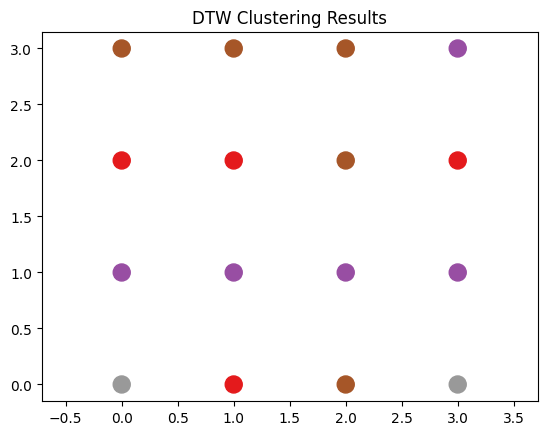

In [4]:
# Visualize the clustering results
x = np.array([i for i in range(len(dtw_landmarks))])%int(len(dtw_landmarks)/4)
y = [0] * int(len(dtw_landmarks)/4) + [1] * int(len(dtw_landmarks)/4) +[2] * int(len(dtw_landmarks)/4) + [3] * int(len(dtw_landmarks)/4)

#plt.scatter(range(len(dtw_landmarks)), [0] * len(dtw_landmarks), c=cluster_labels, cmap='viridis')
plt.scatter(x, y, c=cluster_labels, cmap='Set1', marker='o', s=150, alpha=1)
plt.title('DTW Clustering Results')
plt.axis('equal')
plt.show()

## 3.2 LSTM
Copy from a tutorial

<hr style="color: red">

ChatGPT code tryout

List of hyperparameters:
- **Frame rate** it alsmost certain that the accuracy won't change much between taking all frames and taking every other frame, but what is the lowest frame rate we can take without impacting the results too much?
- **Dimensions** Check wether 3D is significanly more sufficient than 2D
- **Face landmarks** Do the face landmarks contribute much? If yes, how many of them should we take?


In [46]:
SKIP_FRAMES = 4
DIMENSTIONS = 2

In [44]:
words = ["short", "tall", "woman", "man","small", "big", "morning", "afternoon", ]
words = ["play","basketball","morning","tall","dress","beautiful"]

lstm_landmarks = {}
for word in words:
    videos = data_info.loc[data_info.word==word,'video_id']
    for vid in videos:
        lstm_landmarks[vid] = subset_landmarks[vid][::SKIP_FRAMES,POSE+LH+RH,:]
len(lstm_landmarks)

57

In [45]:
lstm_landmarks[list(lstm_landmarks.keys())[40]].shape
#list(lstm_landmarks.keys())[40]
#data_info.loc[data_info.video_id=='56837']

(36, 75, 3)

In [8]:
# Assuming each flattened array has length 543
input_shape = (None, 150)  # Variable number of frames, each with 75 poins, 3D for each as for now, might take 2D later

# Build LSTM model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True))

# You can stack multiple LSTM layers if needed
# model.add(LSTM(units=64, return_sequences=True))

# Add a Dense layer for output
model.add(Dense(units=1, activation='sigmoid'))  # Adjust units and activation as needed

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Generate sample data
# Replace this with your actual data loading and preprocessing
# For example, you might have a list of arrays, where each array corresponds to a frame
# frames_data = [np.random.rand(543) for _ in range(num_frames)]

# Convert the list of arrays into a 3D numpy array for training
# X_train should be a 3D array with shape (num_samples, num_frames, 543)
# y_train should be a 1D array or list of labels
# For example, if you have binary classification, y_train might be [0, 1, 0, 1, ...]
# X_train = np.array([frames_data])
# y_train = np.array([labels])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


2024-02-22 09:34:46.533684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ZeroDivisionError: division by zero

<hr style="color: red">

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [13]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [17]:
subset_landmarks['51221'].shape # (99, 543, 3)
543*3

1629

In [30]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(None,1629)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(words), activation='softmax'))

In [62]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [60]:
## This os a very ugly code, needs a cleanup once I am not stressed with time

X_train = np.array([])
X_val = np.array([])
X_test = np.array([])
y_train = np.array([])
y_val = np.array([])
y_test = np.array([])

for video_id, landmarks in subset_landmarks.items()[:2]:
    if data_info.loc[data_info.video_id==video_id[:5],['word']].iloc[0,0] not in words:
        continue
    print('-',end='')
    if data_info.loc[data_info.video_id==video_id[:5],['split']].iloc[0,0] == 'train':
        X_train = np.append(X_train,landmarks)
        y_train = np.append(y_train,data_info.loc[data_info.video_id==video_id[:5],'word'])
    if data_info.loc[data_info.video_id==video_id[:5],['split']].iloc[0,0] == 'val':
        X_val = np.append(X_val,landmarks)
        y_val = np.append(y_val,data_info.loc[data_info.video_id==video_id[:5],'word'])
    if data_info.loc[data_info.video_id==video_id[:5],['split']].iloc[0,0] == 'test':
        X_test = np.append(X_test,landmarks)
        y_test = np.append(y_test,data_info.loc[data_info.video_id==video_id[:5],'word'])

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
a = np.zeros((5,3))
b = np.ones((5,3))
c = np.zeros((5,3))
a = np.stack((a,b))
a
a = np.hstack((a,c))

In [63]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

ValueError: Data cardinality is ambiguous:
  x sizes: 27412812
  y sizes: 257
Make sure all arrays contain the same number of samples.

In [ ]:
model.summary()